# Bayes Classifier for Hackers

In [2]:
## import all the things
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
## pymc the bayesian model tool
import pymc3 as pm
import theano.tensor as tt
import theano
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" ## flag added to bypass certain model compilation issue
## ml tools
import sklearn.datasets as data
from sklearn.model_selection import train_test_split

from scipy.stats import multivariate_normal, norm

from sklearn.metrics import accuracy_score, roc_auc_score

### This is a naive bayes classfier example/test with Iris dataset

Iris dataset is chosen for its low dimenstionality (3 classes, 4 features)

Quick EDA on the dataset...

### EDA <a class="anchor" id="eda"></a>

In [3]:
X = pd.DataFrame(data.load_iris(as_frame=True)['data'])
y = pd.Series(data.load_iris(as_frame=True)['target'])

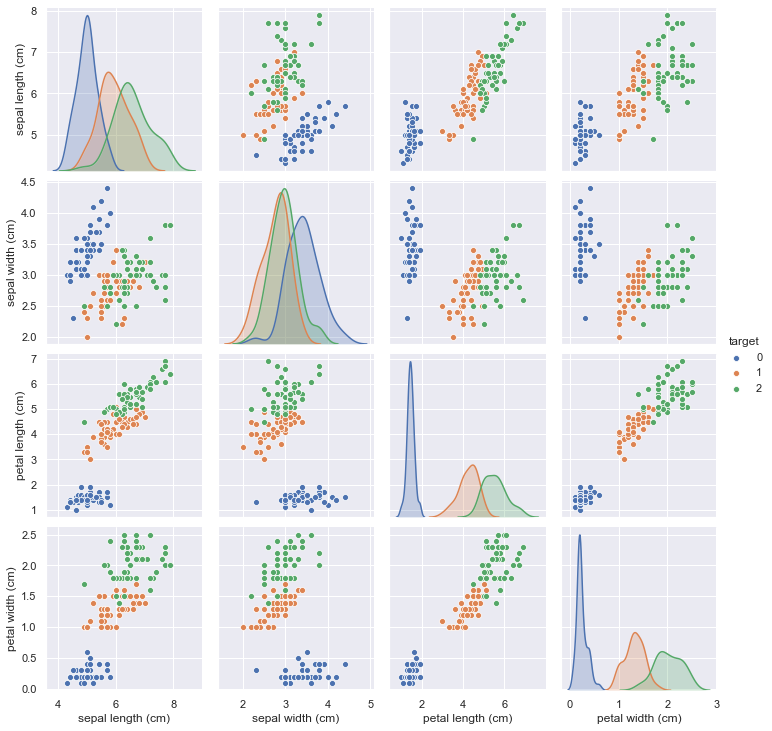

In [4]:
iris = X.copy()
iris['target'] = y
pplot = sns.pairplot(iris, hue="target")

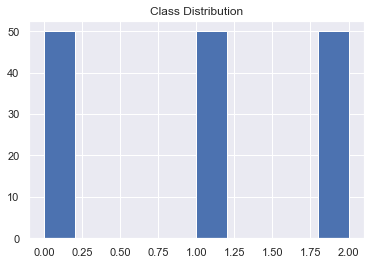

In [5]:
plt.hist(y.astype(int))
plt.title('Class Distribution')
plt.show()

## PyMC3 Model 

I will be modelling it with Multivariate Gaussian Distribution for the features
\begin{align}
X \sim \mathcal{N}(\mu,\,\Sigma)\,.
\end{align}

the classification will be done with 
\begin{align}
P(c|X) ~ P(X|\mu, \Sigma) * P(c)
\end{align}

where...
\begin{array}{c}
c = classes \\
X = features' values \\
\mu = mean/centre \\ 
\Sigma = covariance \\
\end{array}

### Bayesian inference

In bayesian fashion I'll be estimating the parameters of the distributions of each classes. Meaning I'll be building 3 Multivariate normal distribution models (one for each classes) like so: 

\begin{align}
P(\mu, \Sigma|X) = \frac{P(X|\mu, \Sigma) * P( \mu, \Sigma )}{P(X)}
\end{align}

where the priors mu and Sigma will be modeled with, exponential and LKJCholeskyCov** respectively.

** follow this link for more information on why this distribution is used instead of Wishart, https://docs.pymc.io/notebooks/LKJ.html

In [7]:
## putting model building into function
def iris_model(X, y):
    K = len(y.unique())
    with pm.Model() as model:       
        
        for c in y.unique():
            µ = pm.Exponential("µ{}".format(c), lam=1, shape=4)
            packed_L = pm.LKJCholeskyCov('packed_L{}'.format(c), n=4,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
            L = pm.expand_packed_triangular(4, packed_L)
            cov = pm.Deterministic('cov{}'.format(c), L.dot(L.T))
        
            obs = pm.MvNormal('mvgauss{}'.format(c), μ, chol=L, observed=X[y==c])
    
    return model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple

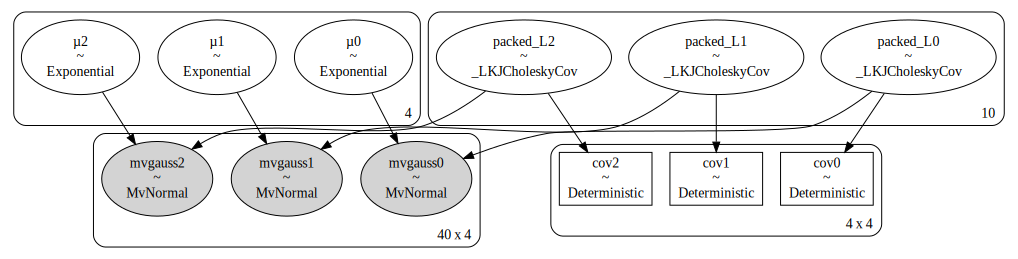

In [9]:
### visualising model to visually confirmed it is specified correctly
pm.model_to_graphviz(iris_model(X_train, y_train))

In [10]:
## run HMC trace
with iris_model(X_train, y_train):
    trace = pm.sample(random_seed=42)

/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.
/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


## Trace diagnostics

/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


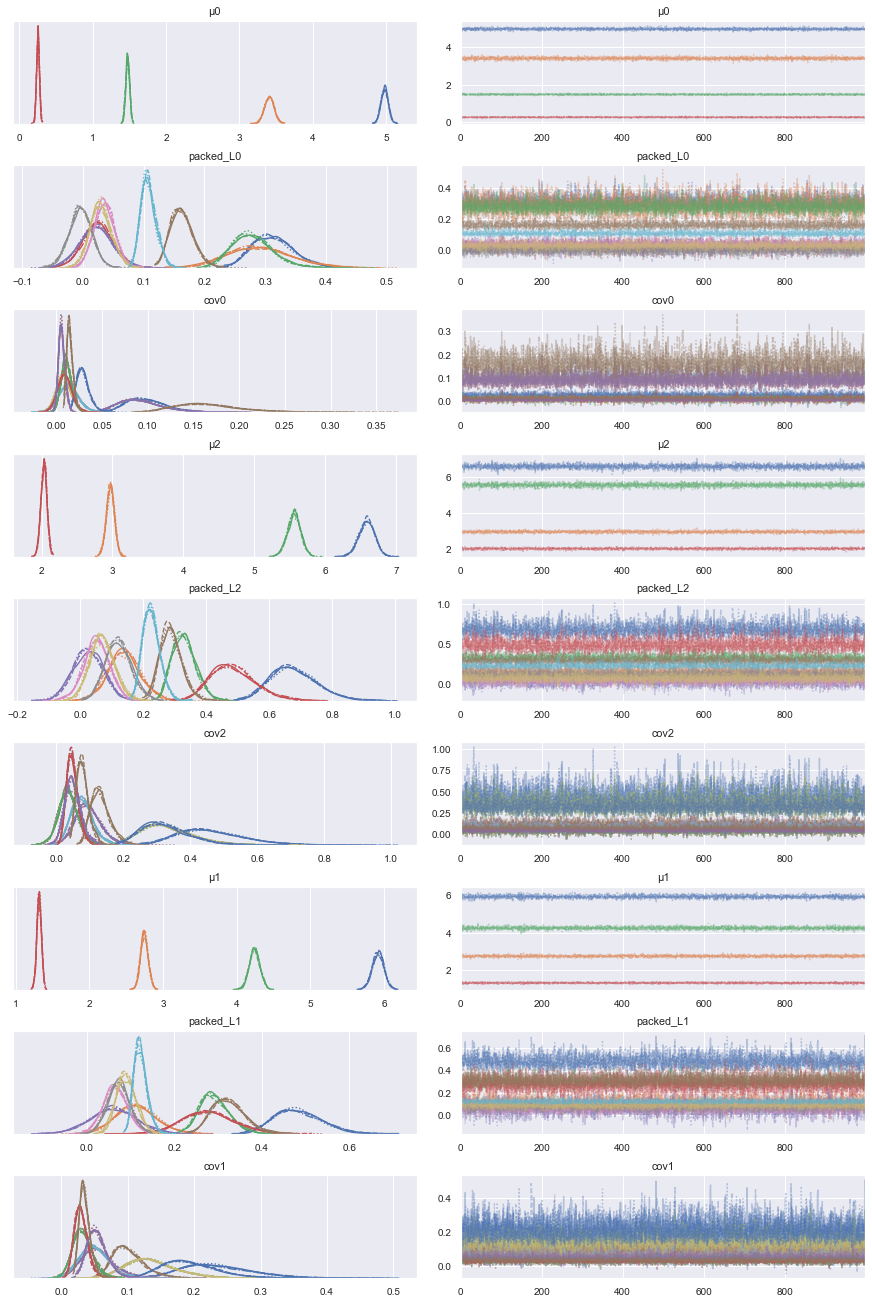

In [11]:
pm.traceplot(trace)
plt.show()

In [12]:
## checking rhat value, should 1 to indicate model convergence 
pm.summary(trace)

/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
µ0[0],4.979,0.049,4.885,5.068,0.001,0.001,3352.0,3352.0,3369.0,2624.0,1.0
µ0[1],3.407,0.064,3.277,3.518,0.001,0.001,3378.0,3378.0,3380.0,3142.0,1.0
µ0[2],1.476,0.026,1.425,1.523,0.000,0.000,4307.0,4307.0,4326.0,3056.0,1.0
µ0[3],0.254,0.020,0.215,0.288,0.000,0.000,3902.0,3902.0,3948.0,2810.0,1.0
packed_L0[0],0.314,0.035,0.252,0.380,0.001,0.000,3349.0,3173.0,3654.0,2789.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"cov1[2,3]",0.055,0.015,0.028,0.083,0.000,0.000,2872.0,2527.0,3241.0,2402.0,1.0
"cov1[3,0]",0.032,0.015,0.005,0.060,0.000,0.000,2979.0,2629.0,3107.0,2552.0,1.0
"cov1[3,1]",0.030,0.010,0.013,0.049,0.000,0.000,3234.0,2838.0,3504.0,2582.0,1.0
"cov1[3,2]",0.055,0.015,0.028,0.083,0.000,0.000,2872.0,2527.0,3241.0,2402.0,1.0


In [13]:
## checking rhat value, should 1 to indicate model convergence 
pm.rhat(trace).values()

/Users/user/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


ValuesView(<xarray.Dataset>
Dimensions:          (cov0_dim_0: 4, cov0_dim_1: 4, cov1_dim_0: 4, cov1_dim_1: 4, cov2_dim_0: 4, cov2_dim_1: 4, packed_L0_dim_0: 10, packed_L1_dim_0: 10, packed_L2_dim_0: 10, µ0_dim_0: 4, µ1_dim_0: 4, µ2_dim_0: 4)
Coordinates:
  * µ0_dim_0         (µ0_dim_0) int64 0 1 2 3
  * packed_L0_dim_0  (packed_L0_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * cov0_dim_0       (cov0_dim_0) int64 0 1 2 3
  * cov0_dim_1       (cov0_dim_1) int64 0 1 2 3
  * µ2_dim_0         (µ2_dim_0) int64 0 1 2 3
  * packed_L2_dim_0  (packed_L2_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * cov2_dim_0       (cov2_dim_0) int64 0 1 2 3
  * cov2_dim_1       (cov2_dim_1) int64 0 1 2 3
  * µ1_dim_0         (µ1_dim_0) int64 0 1 2 3
  * packed_L1_dim_0  (packed_L1_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * cov1_dim_0       (cov1_dim_0) int64 0 1 2 3
  * cov1_dim_1       (cov1_dim_1) int64 0 1 2 3
Data variables:
    µ0               (µ0_dim_0) float64 1.002 1.003 1.002 1.0
    packed_L0        (packed_L0_dim_0) float64

MCMC seems to have converged

## Naive Bayes

Since the fit was fine, we can do quick predictions with Naive Bayes approach.

This is done by computing the probability density (with pdf) using fitted parameters for each class, and selecting the class that has the highest probabilty density of the classes for the value of interest. 

that is, when classifying sample x...

\begin{align}
argmax\{ P(x|\mu_1, \Sigma_1) ,P(x|\mu_2, \Sigma_2), P(x|\mu_3, \Sigma_3)\}
\end{align}



In [14]:
def naivesbayes(X):
    mvnorm_pdf = multivariate_normal.pdf
    samples = X.shape[0]

    c1_p = np.empty((2000, samples))
    c2_p = np.empty((2000, samples))
    c3_p = np.empty((2000, samples))

    for i in range(2000):
        c1_p[i] = mvnorm_pdf(X.values, mean=trace["µ0"][i,:], cov=trace["cov0"][i,:,:])
        c2_p[i] = mvnorm_pdf(X.values, mean=trace["µ1"][i,:], cov=trace["cov1"][i,:,:])
        c3_p[i] = mvnorm_pdf(X.values, mean=trace["µ2"][i,:], cov=trace["cov2"][i,:,:])
        
    y_pred = pd.DataFrame()
    y_pred["0"] = c1_p.mean(0)
    y_pred["1"] = c2_p.mean(0)
    y_pred["2"] = c3_p.mean(0)

    y_pred = y_pred.idxmax(axis=1).astype("int64")
    
    return y_pred

In [15]:
accuracy_score(y_train, naivesbayes(X_train))

0.975

In [16]:
accuracy_score(y_test, naivesbayes(X_test))

1.0

### comparison with MLE implementation from sklearn

In [17]:
from sklearn.naive_bayes import GaussianNB
model_sk = GaussianNB(priors = None)
model_sk.fit(X_train,y_train)

GaussianNB()

In [18]:
accuracy_score(y_test, model_sk.predict(X_test))

0.9666666666666667

In [19]:
accuracy_score(y_train, model_sk.predict(X_train))

0.9583333333333334

### Prediction Probability

In [20]:
def NBpredict_proba(X):
    mvnorm_pdf = multivariate_normal.pdf
    samples = X.shape[0]

    c1_p = np.empty((2000, samples))
    c2_p = np.empty((2000, samples))
    c3_p = np.empty((2000, samples))

    for i in range(2000):
        c1_p[i] = mvnorm_pdf(X.values, mean=trace["µ0"][i,:], cov=trace["cov0"][i,:,:])
        c2_p[i] = mvnorm_pdf(X.values, mean=trace["µ1"][i,:], cov=trace["cov1"][i,:,:])
        c3_p[i] = mvnorm_pdf(X.values, mean=trace["µ2"][i,:], cov=trace["cov2"][i,:,:])
    
    y_proba = np.empty((samples, 3))
    
    for i in range(samples):
        pred = np.vstack((c1_p[:,i],c2_p[:,i],c3_p[:,i])).T
        pred = np.argmax(pred, axis=1)
        c1 = len([a for a in pred if a == 0])/2000
        c2 = len([a for a in pred if a == 1])/2000
        c3 = len([a for a in pred if a == 2])/2000
        y_proba[i] = np.array([c1, c2, c3])
    
    return pd.DataFrame(y_proba)

In [21]:
NBpredict_proba(X_test)

,0,1,2
0,1.0,0.0000,0.0000
1,0.0,0.0270,0.9730
2,0.0,1.0000,0.0000
3,0.0,1.0000,0.0000
4,1.0,0.0000,0.0000
5,0.0,1.0000,0.0000
6,1.0,0.0000,0.0000
7,1.0,0.0000,0.0000
8,0.0,0.0000,1.0000
9,0.0,0.9915,0.0085


In [22]:
roc_auc_score(y_test, NBpredict_proba(X_test),multi_class="ovo")

1.0

In [23]:
roc_auc_score(y_train, NBpredict_proba(X_train),multi_class="ovo")

0.9995833333333334